In [1]:
import os
import sys
import ffmpeg
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize
from pytorch_msssim import ms_ssim
from tqdm import tqdm
import lpips

dcvc_path = os.path.abspath("/h/lkcai/code/video-perception/DCVC_HEM")
if dcvc_path not in sys.path:
    sys.path.insert(0, dcvc_path)
    
hific_path = os.path.abspath("/h/lkcai/code/video-perception/hific")
if hific_path not in sys.path:
    sys.path.insert(0, hific_path)

from hific.compress import prepare_model, prepare_dataloader, \
    compress_and_save, load_and_decompress, compress_and_decompress

from UVG1 import UVG
from ssf_model import ScaleSpaceFlow
from DCVC_HEM.src.models.video_model import DMC
from DCVC_HEM.src.utils.stream_helper import get_padding_size, get_state_dict


device = torch.device('cuda' if torch.cuda.is_available else cpu)
!nvidia-smi

/h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Thu Jan 30 17:35:37 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:86:00.0 Off |                    0 |
| N/A   40C    P0    28W /  70W |   9449MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def load_ssf_model(model, pre_path):
    model.motion_encoder.load_state_dict(torch.load(pre_path + '/m_enc.pth'))
    model.motion_decoder.load_state_dict(torch.load(pre_path + '/m_dec.pth'))
    model.P_encoder.load_state_dict(torch.load(pre_path + '/p_enc.pth'))
    model.res_encoder.load_state_dict(torch.load(pre_path + '/r_enc.pth'))
    model.res_decoder.load_state_dict(torch.load(pre_path + '/r_dec.pth'))
    return model

def hwc_tonp(x):
    x = x.detach().cpu().numpy()
    x = x.transpose([0, 2, 3, 1])
    return x

In [3]:
def PSNR(input1, input2):
    mse = torch.mean((input1 - input2) ** 2)
    psnr = 20 * torch.log10(1 / torch.sqrt(mse))
    return psnr.item()

lpips_vgg = lpips.LPIPS(net='vgg').to(device)
def LPIPS(img1, img2):
    lpips = lpips_vgg(img1, img2)
    return lpips.mean().item()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/lpips/weights/v0.1/vgg.pth


In [4]:
def run_h264(batch, crf=51, preset="medium"):
    batch_recon_frames = []
    for x in batch:
        # [F, C, N, N]
        num_frames, height, width = x.size(0), x.size(2), x.size(3)
        frames = (x * 255).clamp(0, 255).permute(0, 2, 3, 1).cpu().numpy()

        process = (
            ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(width, height))
            .output('pipe:', vcodec='libx264', pix_fmt='rgb24', crf=crf, preset=preset, format='h264')
            .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
        )

        for frame in frames:
            frame = frame.astype(np.uint8)
            process.stdin.write(frame.tobytes())

        process.stdin.close()
        
        compressed_output = process.stdout.read()
        compressed_videos = np.frombuffer(compressed_output, dtype=np.uint8)

        compressed_bits = len(compressed_videos) * 8
        # print("H.264: Total bit length for 3 frames: ", compressed_bits)

        process_decode = (
            ffmpeg
            .input('pipe:', format='h264')
            .output('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(width, height))
            .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
        )

        process_decode.stdin.write(compressed_output)
        process_decode.stdin.close()

        decompressed_output = process_decode.stdout.read()

        recon_frames = np.frombuffer(
            decompressed_output, 
            dtype=np.uint8
        ).reshape(num_frames, height, width, 3)
        
        recon_frames = torch.from_numpy(recon_frames).permute(0, 3, 1, 2)
        recon_frames = recon_frames / 255.
        batch_recon_frames.append(recon_frames)
    
    batch_recon_frames = torch.stack(batch_recon_frames, dim=0)
    
    return batch_recon_frames

In [31]:
def run_dcvc_test(x, rate_idx=0):
    model_path = './DCVC_HEM/checkpoints/acmmm2022_video_ssim.pth.tar'
    p_frame_y_q_scales, p_frame_mv_y_q_scales = DMC.get_q_scales_from_ckpt(model_path)
    
    p_state_dict = get_state_dict(model_path)
    video_net = DMC()
    video_net.load_state_dict(p_state_dict)
    video_net = video_net.to(device)
    video_net.eval()

    x2     = x[:, 1, ...]
    x3     = x[:, 2, ...]
    x1_hat = x[:, 3, ...]
    
    p_frame_y_q_scale = torch.tensor(0.01) # p_frame_y_q_scales[rate_idx]
    p_frame_mv_y_q_scale = torch.tensor(0.01) # p_frame_mv_y_q_scales[rate_idx]

    bbp_2 = []
    bbp_3 = []
    with torch.no_grad():
        h, w = x2.shape[2], x2.shape[3]
        bin_path = None
        dpb = {
            "ref_frame": x1_hat, "ref_feature": None, "ref_y": None, "ref_mv_y": None,
        }
        x2_result = video_net.encode_decode(
            x2, dpb, bin_path,
            pic_height=h, pic_width=w,
            mv_y_q_scale=p_frame_mv_y_q_scale,
            y_q_scale=p_frame_y_q_scale
        )
        dpb = x2_result["dpb"]
        x2_hat = dpb["ref_frame"].clamp_(0, 1)
        bbp_2.append(x2_result['bit'] / (h * w))

        x3_result = video_net.encode_decode(
            x3, dpb, bin_path,
            pic_height=h, pic_width=w,
            mv_y_q_scale=p_frame_mv_y_q_scale,
            y_q_scale=p_frame_y_q_scale
        )
        dpb = x3_result["dpb"]
        x3_hat = dpb["ref_frame"].clamp_(0, 1)
        bbp_3.append(x3_result['bit'] / (h * w))

    avg_bbp_2 = sum(bbp_2) / len(bbp_2)
    avg_bbp_3 = sum(bbp_3) / len(bbp_3)

    return x2_hat, x3_hat, avg_bbp_2, avg_bbp_3

In [11]:
train_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.RandomCrop(256)
])

uvg_dataset = UVG("./data/uvg/", train_transforms)
uvg_dataloader = DataLoader(
    uvg_dataset, batch_size=1, num_workers=4, shuffle=True, pin_memory=True,
)

In [7]:
l_AR = 0.08

ssf_JD = ScaleSpaceFlow().to(device)
ssf_JD.load_state_dict(torch.load('./saved_models/vimeo-90k/JD/ssf_uvg_JD.pth'))

ssf_AR = ScaleSpaceFlow().to(device)
ssf_AR = load_ssf_model(ssf_AR, f'./saved_models/vimeo-90k/AR_{l_AR}/')

ssf_MSE = ScaleSpaceFlow().to(device)
ssf_MSE = load_ssf_model(ssf_MSE, f'./saved_models/vimeo-90k/mse/')

In [8]:
hific_model_path = "./saved_models/vimeo-90k/FMD/hific_hi.pt"
hific_log_path = "./hific/log"

fmd, args = prepare_model(hific_model_path, hific_log_path)

17:36:07 INFO - logger_setup: /fs01/home/lkcai/code/video-perception/hific/compress.py


Building prior probability tables...


100%|██████████| 64/64 [00:00<00:00, 293.95it/s]


Setting up Perceptual loss...


17:36:13 INFO - load_model: Loading model ...
17:36:13 INFO - load_model: Estimated model size (under fp32): 725.903 MB
17:36:13 INFO - load_model: Model init 6.208s


Loading model from: /h/lkcai/code/video-perception/hific/src/loss/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


17:36:14 INFO - prepare_model: Model loaded from disk.
17:36:14 INFO - prepare_model: Building hyperprior probability tables...
100%|██████████| 320/320 [00:00<00:00, 1388.64it/s]
17:36:21 INFO - prepare_model: All tables built.


In [34]:
data = next(iter(uvg_dataloader))

with torch.no_grad():
    x = data[:, :4, ...].to(device)
    x1 = 2 * (data[:, 0, ...] - 0.5).to(device)
    x2 = 2 * (data[:, 1, ...] - 0.5).to(device)
    x3 = 2 * (data[:, 2, ...] - 0.5).to(device)
    x1_hat = 2 * (data[:, 0, ...] - 0.5).to(device) # just copy the first frame

    x2_hat_JD = ssf_JD([x1_hat, x2])
    x2_hat_AR = ssf_AR([x1_hat, x2])

    x3_hat_JD = ssf_JD([x2_hat_JD, x3])
    x3_hat_AR = ssf_AR([x2_hat_AR, x3])

    x2_hat_dcvc, x3_hat_dcvc = run_dcvc_test(x)

    JD_x2_psnr = PSNR(x[:, 1, ...], (x2_hat_JD + 1) * 0.5)
    JD_x3_psnr = PSNR(x[:, 2, ...], (x3_hat_JD + 1) * 0.5)
    print(f"PSNR    - JD   {JD_x2_psnr:.4f}, {JD_x3_psnr:.4f}")

    AR_x2_psnr = PSNR(x[:, 1, ...], (x2_hat_AR + 1) * 0.5)
    AR_x3_psnr = PSNR(x[:, 2, ...], (x3_hat_AR + 1) * 0.5)
    print(f"PSNR    - AR   {AR_x2_psnr:.4f}, {AR_x3_psnr:.4f}")

    DCVC_x2_psnr = PSNR(x[:, 1, ...], x2_hat_dcvc)
    DCVC_x3_psnr = PSNR(x[:, 2, ...], x3_hat_dcvc)
    print(f"PSNR    - DCVC {DCVC_x2_psnr:.4f}, {DCVC_x3_psnr:.4f}")
    
    JD_x2_MSSSIM = ms_ssim((x2_hat_JD + 1) * 0.5, x[:, 1, ...], data_range=1).item()
    JD_x3_MSSSIM = ms_ssim((x3_hat_JD + 1) * 0.5, x[:, 2, ...], data_range=1).item()
    print(f"MS SSIM - JD   {JD_x2_MSSSIM:.4f}, {JD_x3_MSSSIM:.4f}")
    
    AR_x2_MSSSIM = ms_ssim((x2_hat_AR + 1) * 0.5, x[:, 1, ...], data_range=1).item()
    AR_x3_MSSSIM = ms_ssim((x3_hat_AR + 1) * 0.5, x[:, 2, ...], data_range=1).item()
    print(f"MS SSIM - AR   {AR_x2_MSSSIM:.4f}, {AR_x3_MSSSIM:.4f}")
    
    DCVC_x2_MSSSIM = ms_ssim(x2_hat_dcvc, x[:, 1, ...], data_range=1).item()
    DCVC_x3_MSSSIM = ms_ssim(x3_hat_dcvc, x[:, 2, ...], data_range=1).item()
    print(f"MS SSIM - DCVC {DCVC_x2_MSSSIM:.4f}, {DCVC_x3_MSSSIM:.4f}")
    
idx = 0

x1_img = (hwc_tonp((resize(x1, (128, 128)) + 1) * 0.5))[idx]
x2_img = (hwc_tonp((resize(x2, (128, 128)) + 1) * 0.5))[idx]
x3_img = (hwc_tonp((resize(x3, (128, 128)) + 1) * 0.5))[idx]

x1_hat_img    = (hwc_tonp((resize(x1_hat, (128, 128)) + 1) * 0.5))[idx]

x2_hat_JD_img = (hwc_tonp((resize(x2_hat_JD, (128, 128)) + 1) * 0.5))[idx]
x2_hat_AR_img = (hwc_tonp((resize(x2_hat_AR, (128, 128)) + 1) * 0.5))[idx]

x3_hat_JD_img = (hwc_tonp((resize(x3_hat_JD, (128, 128)) + 1) * 0.5))[idx]
x3_hat_AR_img = (hwc_tonp((resize(x3_hat_AR, (128, 128)) + 1) * 0.5))[idx]

x2_hat_dcvc = hwc_tonp(resize(x2_hat_dcvc, (128, 128)))[0]
x3_hat_dcvc = hwc_tonp(resize(x3_hat_dcvc, (128, 128)))[0]

i_frame_q_scale:  tensor(1.5472)
p_frame_y_q_scale:  tensor(4.)
p_frame_mv_y_q_scale tensor(4.)
DCVC Bits per frame : [3037.54638671875, 521.4965209960938]
PSNR    - JD   24.4811, 22.7955
PSNR    - AR   34.4815, 34.4040
PSNR    - DCVC 29.5802, 19.4851
MS SSIM - JD   0.9601, 0.9548
MS SSIM - AR   0.9911, 0.9911
MS SSIM - DCVC 0.9822, 0.7385


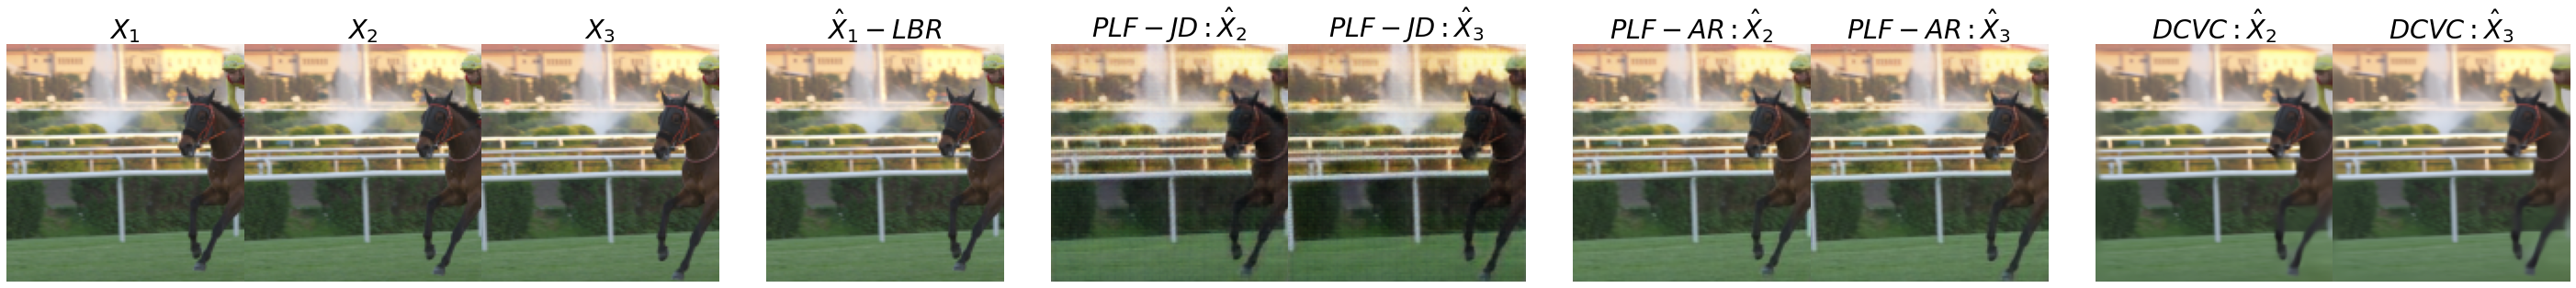

In [35]:
fig = plt.figure()
plt.rcParams.update({'font.size': 24})
fig.set_size_inches(50, 20)

gs = gridspec.GridSpec(1, 14)
gs = gridspec.GridSpec(
    1, 14, 
    width_ratios=[1, 1, 1, 0.2, 1, 0.2, 1, 1, 0.2, 1, 1, 0.2, 1, 1]
)

positions = [0, 1, 2, 4, 6, 7, 9, 10, 12, 13]
axarr = [fig.add_subplot(gs[pos]) for pos in positions]

for ax in axarr:
    ax.axis('off')


axarr[0].set_title('$X_1$')
axarr[0].imshow(x1_img)
axarr[1].set_title('$X_2$')
axarr[1].imshow(x2_img)
axarr[2].set_title('$X_3$')
axarr[2].imshow(x3_img)

axarr[3].set_title('$\hat{X}_1-LBR$')
axarr[3].imshow(x1_hat_img)
axarr[4].set_title('$PLF-JD: \hat{X}_2$')
axarr[4].imshow(x2_hat_JD_img)
axarr[5].set_title('$PLF-JD: \hat{X}_3$')
axarr[5].imshow(x3_hat_JD_img)

axarr[6].set_title('$PLF-AR: \hat{X}_2$')
axarr[6].imshow(x2_hat_AR_img)
axarr[7].set_title('$PLF-AR: \hat{X}_3$')
axarr[7].imshow(x3_hat_AR_img)

axarr[8].set_title('$DCVC: \hat{X}_2$')
axarr[8].imshow(x2_hat_dcvc)
axarr[9].set_title('$DCVC: \hat{X}_3$')
axarr[9].imshow(x3_hat_dcvc)

plt.subplots_adjust(wspace=0.0)

letter = 'k'
os.makedirs(f'./reconstructions/R1-eps(uvg)/{letter}/', exist_ok=True)

plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x1.png", x1_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x2.png", x2_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x3.png", x3_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x1_hat.png", x1_hat_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x2_hat_JD.png", x2_hat_JD_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x2_hat_AR.png", x2_hat_AR_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x3_hat_JD.png", x3_hat_JD_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x3_hat_AR.png", x3_hat_AR_img)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x2_hat_DCVC.png", x2_hat_dcvc)
plt.imsave(f"./reconstructions/R1-eps(uvg)/{letter}/x3_hat_DCVC.png", x3_hat_dcvc)

In [32]:
mse_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
jd_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
fmd_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
ar_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
dcvc_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}

dcvc_bbp_x2 = []
dcvc_bbp_x3 = []

length = 50
test_loader = itertools.islice(uvg_dataloader, length)

ssf_JD.eval()
ssf_AR.eval()
ssf_MSE.eval()
fmd.eval()

for data in tqdm(test_loader):
    with torch.no_grad():
        x = data[:, :4, ...].to(device)
        # x1 = 2 * (data[:, 0, ...] - 0.5).to(device)
        x2 = 2 * (data[:, 1, ...] - 0.5).to(device)
        x3 = 2 * (data[:, 2, ...] - 0.5).to(device)
        x1_hat = 2 * (data[:, 0, ...] - 0.5).to(device)
        
        x2_hat_JD = ssf_JD([x1_hat, x2])
        x2_hat_AR = ssf_AR([x1_hat, x2])
#         x2_hat_AR = (x2_hat_AR - x2_hat_AR.min()) / (x2_hat_AR.max() - x2_hat_AR.min())
        x2_hat_MSE = ssf_MSE([x1_hat, x2])

        x3_hat_JD = ssf_JD([x2_hat_JD, x3])
        x3_hat_AR = ssf_AR([x2_hat_AR, x3])
#         x3_hat_AR = (x3_hat_AR - x3_hat_AR.min()) / (x3_hat_AR.max() - x3_hat_AR.min())
        x3_hat_MSE = ssf_MSE([x2_hat_MSE, x3])

        x2_hat_FMD, _ = fmd(x2)
        x3_hat_FMD, _ = fmd(x3)

        x2_hat_dcvc, x3_hat_dcvc, bbp_x2, bbp_x3 = run_dcvc_test(x, rate_idx=3)
        dcvc_bbp_x2.append(bbp_x2)
        dcvc_bbp_x3.append(bbp_x3)

        mse_eval['2_psnr'] += PSNR(x2, x2_hat_MSE)
        mse_eval['3_psnr'] += PSNR(x3, x3_hat_MSE)
        mse_eval['2_lpips'] += LPIPS(x2, x2_hat_MSE)
        mse_eval['3_lpips'] += LPIPS(x3, x3_hat_MSE)

        jd_eval['2_psnr'] += PSNR(x2, x2_hat_JD)
        jd_eval['3_psnr'] += PSNR(x2, x3_hat_JD)
        jd_eval['2_lpips'] += LPIPS(x2, x2_hat_JD)
        jd_eval['3_lpips'] += LPIPS(x3, x3_hat_JD)
        
        fmd_eval['2_psnr'] += PSNR(x2, 2 * x2_hat_FMD - 1.)
        fmd_eval['3_psnr'] += PSNR(x3, 2 * x3_hat_FMD - 1.)
        fmd_eval['2_lpips'] += LPIPS(x2, 2 * x2_hat_FMD - 1.)
        fmd_eval['3_lpips'] += LPIPS(x3, 2 * x3_hat_FMD - 1.)

        ar_eval['2_psnr'] += PSNR(x2, x2_hat_AR)
        ar_eval['3_psnr'] += PSNR(x3, x3_hat_AR)
        ar_eval['2_lpips'] += LPIPS(x2, x2_hat_AR)
        ar_eval['3_lpips'] += LPIPS(x3, x3_hat_AR)
        
        dcvc_eval['2_psnr'] += PSNR(x2, 2 * x2_hat_dcvc - 1.)
        dcvc_eval['3_psnr'] += PSNR(x3, 2 * x3_hat_dcvc - 1.)
        dcvc_eval['2_lpips'] += LPIPS(x2, 2 * x2_hat_dcvc - 1.)
        dcvc_eval['3_lpips'] += LPIPS(x3, 2 * x3_hat_dcvc - 1.)

avg_bbp_2 = sum(dcvc_bbp_x2) / len(dcvc_bbp_x2)
avg_bbp_3 = sum(dcvc_bbp_x3) / len(dcvc_bbp_x3)
print(f"DCVC avg bbp 2 frame: {avg_bbp_2}")
print(f"DCVC avg bbp 3 frame: {avg_bbp_3}")

print('Second frame PSNR:  ' + \
      f'MSE {mse_eval["2_psnr"] / length:.4f} | JD {jd_eval["2_psnr"] / length:.4f} | ' + \
      f'FMD {fmd_eval["2_psnr"] / length:.4f} | AR {ar_eval["2_psnr"] / length:.4f} | ' + \
      f'DCVC {dcvc_eval["2_psnr"] / length:.4f}')
print('Second frame LPIPS: ' + \
      f'MSE {mse_eval["2_lpips"] / length:.4f} | JD {jd_eval["2_lpips"] / length:.4f} | ' + \
      f'FMD {fmd_eval["2_lpips"] / length:.4f} | AR {ar_eval["2_lpips"] / length:.4f} | ' + \
      f'DCVC {dcvc_eval["2_lpips"] / length:.4f}')

print('Third frame PSNR:  ' + \
      f'MSE {mse_eval["3_psnr"] / length:.4f} | JD {jd_eval["3_psnr"] / length:.4f} | ' + \
      f'FMD {fmd_eval["3_psnr"] / length:.4f} | AR {ar_eval["3_psnr"] / length:.4f} | ' + \
      f'DCVC {dcvc_eval["3_psnr"] / length:.4f}')
print('Third frame LPIPS: ' + \
      f'MSE {mse_eval["3_lpips"] / length:.4f} | JD {jd_eval["3_lpips"] / length:.4f} | ' + \
      f'FMD {fmd_eval["3_lpips"] / length:.4f} | AR {ar_eval["3_lpips"] / length:.4f} | ' + \
      f'DCVC {dcvc_eval["3_lpips"] / length:.4f}')

# jd_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
# fmd_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
# ar_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
# dcvc_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
# h264_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}

# length = 20
# test_loader = itertools.islice(uvg_dataloader, length)

# for data in tqdm(test_loader):
#     with torch.no_grad():
#         x = data[:, :4, ...].to(device)
#         x1 = 2 * (data[:, 0, ...] - 0.5).to(device)
#         x2 = 2 * (data[:, 1, ...] - 0.5).to(device)
#         x3 = 2 * (data[:, 2, ...] - 0.5).to(device)
#         x1_hat = 2 * (data[:, 0, ...] - 0.5).to(device)

#         x2_hat_JD = ssf_JD([x1_hat, x2])
#         x2_hat_AR = ssf_AR([x1_hat, x2])

#         x3_hat_JD = ssf_JD([x2_hat_JD, x3])
#         x3_hat_AR = ssf_AR([x2_hat_AR, x3])
        
#         x2_hat_FMD, _ = fmd(data[:, 1, ...].to(device))
#         x3_hat_FMD, _ = fmd(data[:, 2, ...].to(device))
#         x2_hat_FMD -= x2_hat_FMD.min()
#         x2_hat_FMD /= x2_hat_FMD.max()
#         x3_hat_FMD -= x3_hat_FMD.min()
#         x3_hat_FMD /= x3_hat_FMD.max()

#         x2_hat_dcvc, x3_hat_dcvc = run_dcvc_test(x)

#         x_hat_h264 = run_h264(x[:, :3, ...], crf=51)
#         x2_hat_h264 = x_hat_h264[:, 1, :, :, :].to(device)
#         x3_hat_h264 = x_hat_h264[:, 2, :, :, :].to(device)

#         jd_eval['2_psnr'] += PSNR(x[:, 1, ...], (x2_hat_JD + 1) * 0.5)
#         jd_eval['3_psnr'] += PSNR(x[:, 2, ...], (x3_hat_JD + 1) * 0.5)
#         jd_eval['2_lpips'] += LPIPS((x2_hat_JD + 1) * 0.5, x[:, 1, ...])
#         jd_eval['3_lpips'] += LPIPS((x3_hat_JD + 1) * 0.5, x[:, 2, ...])
        
#         fmd_eval['2_psnr'] += PSNR(x[:, 1, ...], x2_hat_FMD)
#         fmd_eval['3_psnr'] += PSNR(x[:, 2, ...], x3_hat_FMD)
#         fmd_eval['2_lpips'] += LPIPS(x2_hat_FMD, x[:, 1, ...])
#         fmd_eval['3_lpips'] += LPIPS(x3_hat_FMD, x[:, 2, ...])

#         ar_eval['2_psnr'] += PSNR(x[:, 1, ...], (x2_hat_AR + 1) * 0.5)
#         ar_eval['3_psnr'] += PSNR(x[:, 2, ...], (x3_hat_AR + 1) * 0.5)
#         ar_eval['2_lpips'] += LPIPS((x2_hat_AR + 1) * 0.5, x[:, 1, ...])
#         ar_eval['3_lpips'] += LPIPS((x3_hat_AR + 1) * 0.5, x[:, 2, ...])
        
#         dcvc_eval['2_psnr'] += PSNR(x[:, 1, ...], x2_hat_dcvc)
#         dcvc_eval['3_psnr'] += PSNR(x[:, 2, ...], x3_hat_dcvc)
#         dcvc_eval['2_lpips'] += LPIPS(x2_hat_dcvc, x[:, 1, ...])
#         dcvc_eval['3_lpips'] += LPIPS(x3_hat_dcvc, x[:, 2, ...])

#         h264_eval['2_psnr'] += PSNR(x[:, 1, ...], x2_hat_h264)
#         h264_eval['3_psnr'] += PSNR(x[:, 2, ...], x3_hat_h264)
#         h264_eval['2_lpips'] += LPIPS(x2_hat_h264, x[:, 1, ...])
#         h264_eval['3_lpips'] += LPIPS(x3_hat_h264, x[:, 2, ...])

# print(f'Second frame PSNR:  JD {jd_eval["2_psnr"] / length:.4f} | FMD {fmd_eval["2_psnr"] / length:.4f} | ' + \
#       f'AR {ar_eval["2_psnr"] / length:.4f} | DCVC {dcvc_eval["2_psnr"] / length:.4f} | ' + \
#       f'H.264 {h264_eval["2_psnr"] / length:.4f}')
# print(f'Second frame LPIPS: JD {jd_eval["2_lpips"] / length:.4f} | FMD {fmd_eval["2_lpips"] / length:.4f} | ' + \
#       f'AR {ar_eval["2_lpips"] / length:.4f} | DCVC {dcvc_eval["2_lpips"] / length:.4f} | ' + \
#       f'H.264 {h264_eval["2_lpips"] / length:.4f}')

# print(f'Third frame PSNR:  JD {jd_eval["3_psnr"] / length:.4f} | FMD {fmd_eval["3_psnr"] / length:.4f} | ' + \
#       f'AR {ar_eval["3_psnr"] / length:.4f} | DCVC {dcvc_eval["3_psnr"] / length:.4f} | ' + \
#       f'H.264 {h264_eval["3_psnr"] / length:.4f}')
# print(f'Third frame LPIPS: JD {jd_eval["3_lpips"] / length:.4f} | FMD {fmd_eval["3_lpips"] / length:.4f} | ' + \
#       f'AR {ar_eval["3_lpips"] / length:.4f} | DCVC {dcvc_eval["3_lpips"] / length:.4f} | ' + \
#       f'H.264 {h264_eval["3_lpips"] / length:.4f}')

50it [01:10,  1.42s/it]

DCVC avg bbp 2 frame: 4.490548024177551
DCVC avg bbp 3 frame: 4.81002384185791
Second frame PSNR:  MSE 26.5766 | JD 18.4709 | FMD 26.4099 | AR 27.6561 | DCVC 28.8988
Second frame LPIPS: MSE 0.1545 | JD 0.3992 | FMD 0.1373 | AR 0.1240 | DCVC 0.0976
Third frame PSNR:  MSE 26.4808 | JD 15.3906 | FMD 26.3944 | AR 27.5382 | DCVC 29.6888
Third frame LPIPS: MSE 0.1584 | JD 0.4040 | FMD 0.1371 | AR 0.1271 | DCVC 0.0779
